In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import librosa
import soundfile
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Emotion-Detection/TESS/

/content/drive/MyDrive/Emotion-Detection/TESS


We use a function that extracts features from an audio file.

In [4]:
def extract_features(file, **kwargs):
    """
    Features supported:
        - MFCC (mfcc)
        - Chroma (chroma)
        - Mel Spectrogram Frequency (mel)
        - Contrast (contrast)
        - Tonnetz (tonnetz)
    e.g:
    'features = extract_features(path, mel=True, mfcc=True)'
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

Here we only use the features MFCC, Chroma and Mel, which are defined as follows:

mfcc: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound.

chroma: Pertains to the 12 different pitch classes.

mel: Mel Spectrogram Frequency.

In [5]:
X, y = [], []
for folder in os.listdir():
    for file in os.listdir(folder):
        name = file.split('.')[0]
        emotion = name.split('_')[2] # get emotion for each file
        features = extract_features(folder + '/' + file, mfcc=True, chroma=True, mel=True) # get features for each file
        X.append(features)
        y.append(emotion)

In [6]:
print(f"Set of emotions is {set(y)}.")

Set of emotions is {'happy', 'ps', 'disgust', 'neutral', 'fear', 'sad', 'angry'}.


"ps" means pleasantly surprised. We now split the dataset into training and test sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, shuffle=True, random_state=0)
print(f"There are {X_train.shape[0]} training samples and {X_test.shape[0]} test samples. There are {X_train.shape[1]} features.")

There are 2240 training samples and 560 test samples. There are 180 features.


We train a Multi-layer Perceptron classifier model.

In [8]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500, random_state=0)
model.fit(X_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500, random_state=0)

In [9]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)
print(f"Training accuracy of MLP Classifier is {accuracy_score(y_train, predict_train)}")
print(f"Test accuracy of MLP Classifier is {accuracy_score(y_test, predict_test)}")

Training accuracy of MLP Classifier is 1.0
Test accuracy of MLP Classifier is 0.9946428571428572


We also plot the confusion matrix on the test set which counts the number of data for each combination of (true label, predicted label).

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting `normalise=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # interpolation = 'none' works well when a big image is scaled down, while
    # interpolation = 'nearest' works well when a small image is scaled up.
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.colorbar() # bar on the right
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # take row sums then turn every element in resulting vector into array
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black") # text in row i and column j
    plt.tight_layout() # automatically adjusts plot parameters so that text doesn't overlap with margins
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

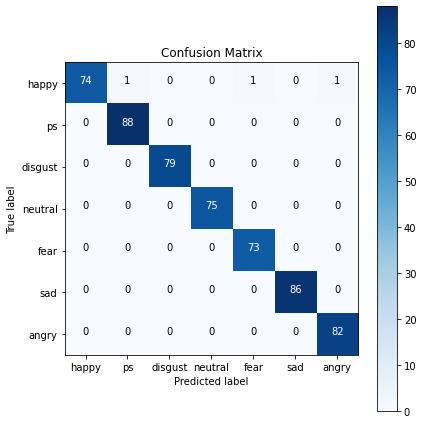

In [19]:
MLP_confusion_mtx = confusion_matrix(y_test, predict_test, labels=list(set(y)))
# true labels as rows, predicted labels as columns
plot_confusion_matrix(MLP_confusion_mtx, list(set(y))) 